In [34]:
import itertools
import json
import math
import os
import pprint
import random
import requests
import time

import numpy as np
import torch
import torchvision
import requests
import zipfile

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T

from io import BytesIO
from PIL import Image

# Lakota AI Code Camp Lesson 18: Object Detection Datasets

Machine learning basically requires three things:
1.  Data;
1.  Model;
1.  Training (aka an optimization method).
Today we're going to learn about the data portion by describing some essential datasets for object detection and image recognition.

First, we'll talk about one of the earlier image recognition/object detection datasets: Pascal VOC (visual objects classes).
Next, we'll talk about Microsoft COCO (common objects in context).
Then, we'll talk about Objects 365, although we won't get too into the dataset, as it requires a license, which we do not have.

Finally, we'll talk about ImageNet and the MNIST variations, which we've seen before.
We'll be training image recognition models.

## Pascal VOC

The Pascal VOC began as an image recognition and object detection challenge that ran from February 2005 to March 2005.
It image recognition task required the detection of: bicycles, cars, motorbikes, people.
There were a total of 1578 images, which were culled from public datasets.
The object detection task included 2209 annotations.
For the classification task, the competition used:
*   the Equal Error Rate (EER), the rate at which the number of false positives is equal to the number of false negatives;
*   area under the receiver operatoring characteristic curve.

The object detection task measured the average precision from 0 to 1, with steps of 0.1.
The 2005 competition had 12 entrants.

By 2012, the challenge extended to
*   classification;
*   detection;
*   segmentation;
*   action classification.

The dataset contained 11,530 images taken from the flickr image sharing website.
There were 7 teams entering the 2012 competition.



In [2]:
voc_list = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus',
            'car', 'motorbike', 'train', 'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa',
            'tvmonitor']

In [3]:
voc_class_dict = {key: i for i, key in enumerate(voc_list)}

In [4]:
def show_bounding_boxes(img, boxes):
    fig, ax = plt.subplots(figsize=(473 / 40, 1260 / 40))

    # Display the image
    ax.imshow(img)

    # Create a Rectangle patch
    rect = []
    for b in boxes:
        rectangle = b['bndbox']
        x_bl = int(rectangle['xmin'])
        y_bl = int(rectangle['ymin'])
        x_tr = int(rectangle['xmax'])
        y_tr = int(rectangle['ymax'])
        w = x_tr - x_bl
        h = y_tr - y_bl
        obj = b['name']
        rect.append((x_bl, y_bl, w, h, obj))


    # Add the patch to the Axes
    for r in rect:
        x, y, w, h = r[:4]

        ax.add_patch(
            patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        )
        plt.annotate(r[-1], (x, y), color='green')

    plt.show()

In [5]:
transform = T.Compose([T.ToTensor()])

In [6]:
download = False if os.path.exists('VOC_data') else True

In [7]:
ds = torchvision.datasets.VOCDetection(root='VOC_data', download=download,
                                       transform=transform,
                                       )

100%|██████████| 1999639040/1999639040 [00:54<00:00, 36974957.35it/s]


Extracting VOC_data/VOCtrainval_11-May-2012.tar to VOC_data


In [8]:
num = np.random.randint(low=0, high=len(ds))

In [9]:
pprint.pprint(ds[num][1])

{'annotation': {'filename': '2008_008578.jpg',
                'folder': 'VOC2012',
                'object': [{'bndbox': {'xmax': '500',
                                       'xmin': '132',
                                       'ymax': '238',
                                       'ymin': '32'},
                            'difficult': '0',
                            'name': 'sofa',
                            'occluded': '1',
                            'pose': 'Frontal',
                            'truncated': '1'},
                           {'bndbox': {'xmax': '284',
                                       'xmin': '22',
                                       'ymax': '307',
                                       'ymin': '184'},
                            'difficult': '0',
                            'name': 'dog',
                            'occluded': '1',
                            'pose': 'Right',
                            'truncated': '0'},
                           {'

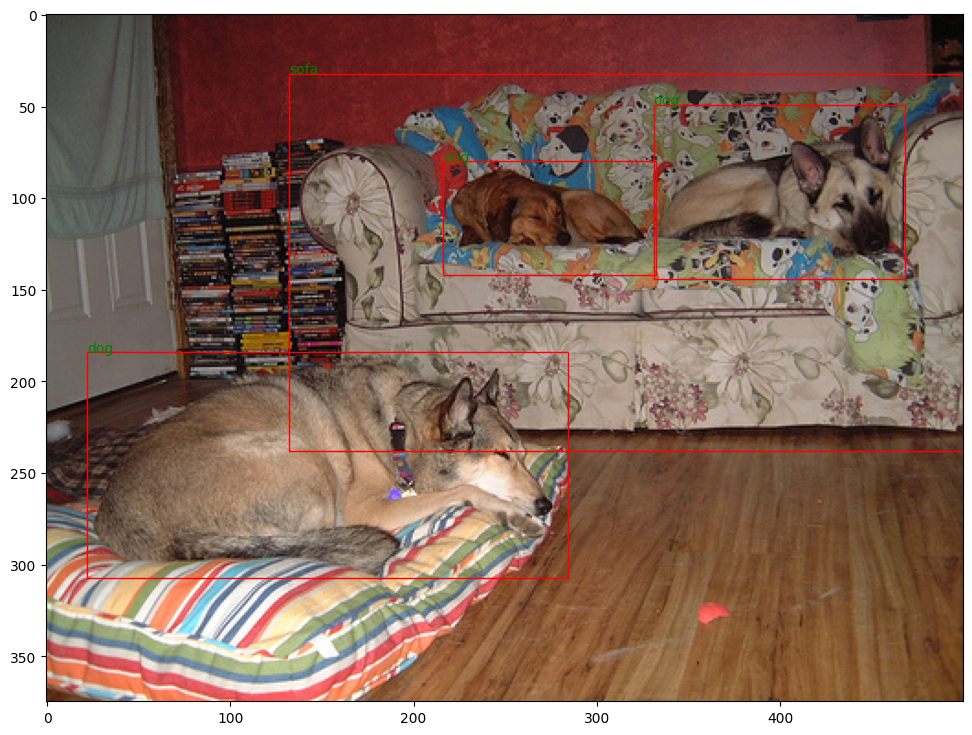

In [10]:
img = ds[num][0].permute(1, 2, 0).numpy()
boxes = ds[num][1]['annotation']['object']

show_bounding_boxes(img, boxes)

## Microsoft Common Objects in Context

MS COCO (**M**icro**s**oft **c**ommon **o**bjects in **co**ntext) is a dataset dedicated to
*   image recognition;
*   object detection;
*   segmentation.

There are 91 categories in the dataset.
The 2014 dataset contains 82,783 training images, 40,504 validation images, and 40,775 testing images, for 164,042 labeled images.
The images were also collected from Flickr.
The labels were crowdsourced using Amazon's Mechanical Turk.

The object detection used various versions of average precision to evaluate candidates for the COCO evaluation.

In [38]:
val2017_url = "http://images.cocodataset.org/zips/val2017.zip"
val2017_json_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

In [39]:
os.makedirs('./data/coco/val2017')
os.makedirs('./data/coco/annotations')

FileExistsError: ignored

In [15]:
r = requests.get(val2017_url)

In [16]:
with open('./data/coco/val2017.zip', 'wb') as f:
    for chunk in r.iter_content(chunk_size=128):
        f.write(chunk)

In [21]:
with zipfile.ZipFile('./data/coco/val2017.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/coco')

In [40]:
r = requests.get(val2017_json_url)

In [41]:
with open('./data/coco/annotations_trainval2017.zip', 'wb') as f:
    for chunk in r.iter_content(chunk_size=128):
        f.write(chunk)

In [47]:
with zipfile.ZipFile("./data/coco/annotations_trainval2017.zip","r") as zip_ref:
    zip_ref.extractall("./data/coco/")

In [48]:
!ls ./data/coco/annotations/

annotations		  person_keypoints_train2017.json
captions_train2017.json   person_keypoints_val2017.json
captions_val2017.json	  stuff_train2017.json
deprecated-challenge2017  stuff_train2017_pixelmaps.zip
instances_train2017.json  stuff_val2017.json
instances_val2017.json	  stuff_val2017_pixelmaps.zip


In [49]:
coco_ds = torchvision.datasets.CocoDetection(root='./data/coco/val2017',
                                             annFile='./data/coco/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [52]:
with open('./data/coco/annotations/instances_val2017.json', 'r') as f:
    coco_cats = json.load(f)

In [53]:
categories = [0] * 91

for c in coco_cats['categories']:
    categories[c['id']] = c['name']

In [57]:
def coco_img_show(img, label):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    rect = []
    for t in label:
        rectangle = t['bbox']
        x, y, w, h = rectangle
        obj = t['category_id']
        rect.append((x, y, w, h, obj))

    # Add the patch to the Axes
    for r in rect:
        x, y, w, h = r[:4]

        ax.add_patch(
            patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        )
        plt.annotate(categories[r[-1]], (x, y), color='green')


    plt.show()

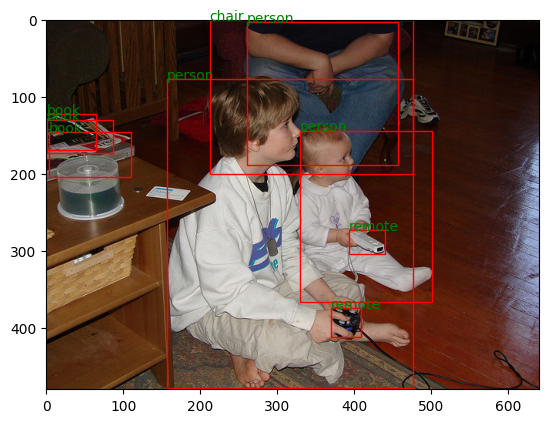

In [66]:
num = np.random.randint(low=0, high=len(coco_ds))

image, label = coco_ds[num]

coco_img_show(image, label)

## Objects 365

Objects 365 gets its name from the fact that there are 365 categories in the dataset.
The training dataset is much larger than either MSCOCO or Pascal VOC.
The dataset contains 638,000 images, with 600,000 images for training, 38,000 images for validation, and 100,000 images for testing (although, it has much more images now).
As in the previous datasets, the images came from Blickr

Although we don't have a license (and concerns above download size), we can use the exploration tool available on the homepage to examine images in the dataset:

[Objects 365 Exploration](https://www.objects365.org/explore.html)